In [1]:
%matplotlib inline
from pylab import *
import numpy as np

In [2]:
# set parameter values
sigma = 0.5 # risk aversion
beta = 0.98 # discount factor
prob = np.array([[0.8, 0.2],[0.5,0.5]]) # prob(i,j) = probability (s(t+1)=sj | s(t) = s(i)
                                        # e_h' e_h, e_l' e_h
                                        # e_h' e_l, e_l e_l
theta = 0.0 # non-interest income if unemployed
wage = 0.5 # non-interest income if employed
Rstart = 1.021 # initial gross interest rate
F = -2.0 # borrowing constraint
g = 0.60 # relaxation parameter

# form asset grid
maxast = 10.0 # maximum value of asset grid
minast = F # minimum value of asset grid
incast = 0.01 # size of asset grid increments
nasset = np.int(np.round((maxast-minast)/incast + 1)) # number of grid points
# loop to find R such that sum(Lambda*A) = 0
# i.e. net asset position accross households is zero
liter = 1
maxiter = 50
toler = 0.0001
step = 0.05
R = Rstart
flag = 1
print('ITERATING ON R')
print('')
print(' liter   R   A   newstep')

while flag !=0 and liter<= maxiter:
    #tabulate the utility function such that for zero or negative 
    #consumption, utility remains a large negative number so that
    #such values will never be chosen as utility maximising
    util1 = -10000.0*np.ones((nasset,nasset)) #utility when employed
    util2 = -10000.0*np.ones((nasset,nasset)) #utility when unemployed
    for i in range(0,nasset):
        asset = (i)*incast + minast #this period asset
        for j in range(0,nasset):
            assetp = (j)*incast + minast #next period asset 
            cons = wage + R*asset - assetp #consumption
            if assetp >= F and cons >0.0: # asset choice above borrowing constraint, consumption positive
                if sigma==1.0:
                    util1[j,i] = np.log(cons)
                else:
                    util1[j,i] = cons**(1.0-sigma)/(1.0-sigma)
        for j in range(0,nasset):
            assetp = (j)*incast + minast
            cons = theta*wage + R*asset - assetp
            if assetp >= F and cons >0.0: # asset choice above borrowing constraint, consumption positive
                if sigma==1.0:
                    util2[j,i] = np.log(cons)
                else:
                    util2[j,i] = cons**(1.0-sigma)/(1.0-sigma)
    #
    # initialize some variables
    #
    v = np.zeros((nasset,2))
    decis = np.zeros((nasset,2))
    test1 = 10.0
    test2 = 10.0
    [rs,cs] = util1.shape
    r1 = np.empty((rs,cs))
    r2 = np.empty((rs,cs))
    #
    #  iterate on Bellman's equation and get the decision 
    #  rules and the value function at the optimum         
    #
    itera=1
    while test1 != False or test2 > 0.1:
        for i in range(0,cs):
            #Bellman employed
            r1[:,i] = util1[:,i] + beta*(prob[0,0]*v[:,0] + prob[0,1]*v[:,1])
            #Bellman unemployed
            r2[:,i] = util2[:,i] + beta*(prob[1,0]*v[:,0] + prob[1,1]*v[:,1])
    
        #find optimal decision
        # max value - employed
        tv1 = np.amax(r1,0) 
        # max position - employed
        tdecis1 = np.argmax(r1, axis=0)
        # max value - unemployed
        tv2 = np.amax(r2,0)
        # max position - unemployed
        tdecis2 = np.argmax(r2, axis=0)

        #stack into one
        tdecis = np.vstack([[tdecis1.T],[tdecis2.T]]).T
        tv = np.vstack([[tv1],[tv2]]).T

        # iterate until not improving value any more
        # not changing position
        test1 = np.any(tdecis-decis)
        # not changing value
        test2 = np.max((np.max(np.abs(tv-v),axis=0)))
        v = tv
        decis = tdecis

    # transform choice into asset level
    decis = decis*incast + minast
    #
    #   form transition matrix
    #   trans is the transition matrix from state at t (row)
    #   to the state at t+1 (column) 
    # 
    g2 = np.zeros((cs,cs)) # unemployed
    g1 = np.zeros((cs,cs)) # employed
    for i in range (0,cs):
        g1[i,tdecis1[i]] = 1.0 # set to one where utility maximised (zero out choices which are not maximising)
        g2[i,tdecis2[i]] = 1.0

    # matrix of transition probabilities
    trans = np.vstack([np.hstack([prob[0,0]*g1, prob[0,1]*g1]),np.hstack([prob[1,0]*g2, prob[1,1]*g2])]).T
    # initial guess for matrix of stationary probabilites 
    probst = (1.0/(2.0*nasset))*np.ones((2.0*nasset,1.0))
    test = 1.0  
    while test > 10**(-8):
        # iteration until probabilities stop changing (stationary probabilities)
        probst1 = np.dot(trans,probst)
        test = np.max(np.abs(probst1-probst))
        probst = probst1
    #
    #   vectorize the decision rule to be conformable with probst
    #   calculate new aggregate asset meanA 
    #
    aa = decis.flatten('F')
    meanA = np.dot(probst.T,aa)
    #
    #  calculate measure over (k,s) pairs
    #  lambda has same dimensions as decis
    #
    Lambda = np.zeros((cs,2))
    Lambda = np.hstack([probst[0:cs],probst[cs:]])
    #
    # calculate stationary distribution of k
    #
    probk=np.sum(Lambda.T,axis=0).T       #  stationary distribution of `capital' 
    #
    # form metric and update R
    #
    if liter == 1:
        A = meanA
        if meanA > 0.0:
            step = -step
    
    Aold = A
    Anew = meanA
    if np.sign(Aold) != np.sign(Anew):
        step = -0.5*step

    print([liter, R , meanA, step])

    if np.abs(step) >= toler:
        R = R + step
    else:
        flag = 0
    
    A = Anew
    liter = liter + 1

# 
# Calculate consumption and expected utility
#
# grid of agents
agrid = np.linspace(minast,maxast, (maxast-minast)/incast + 1).T
# good consumption = wage + return on savings  - asset choice
congood = wage + R*agrid - agrid[tdecis[:,0]]
conbad  = theta*wage + R*agrid - agrid[tdecis[:,1]]
consum = np.vstack([[congood, conbad]]).T
cons2 = consum**2.0
meancon = sum(np.diag(np.dot(Lambda.T,consum)))
meancon2 = sum(np.diag(np.dot(Lambda.T,cons2)))
varcon = meancon2 - meancon**2.0
consum = np.array(consum,dtype=complex)
# utility
UTILITY = consum**(1-sigma)/(1-sigma)
# average utility
UCEU2 = sum(np.diag(np.dot(Lambda.T,UTILITY)))
UCEU2 = np.real([UCEU2])

#
# print out results
#
print('PARAMETER VALUES')
print('')
print('sigma beta    F   theta')
print([sigma, beta, F, theta])
print('')
print('EQUILIBRIUM RESULTS')
print('')
print('          R                    A                  UCEU                 meancon               varcon')
print([R, meanA[0], UCEU2[0], meancon, varcon])


ITERATING ON R

 liter   R   A   newstep
[1, 1.021, array([ 7.67921188]), -0.05]
[2, 0.9709999999999999, array([-1.70919631]), 0.025]
[3, 0.9959999999999999, array([-1.37857382]), 0.025]
[4, 1.021, array([ 7.67921188]), -0.0125]
[5, 1.0085, array([-0.68851382]), 0.00625]
[6, 1.01475, array([-0.0746571]), 0.00625]
[7, 1.0210000000000001, array([ 7.67921188]), -0.003125]
[8, 1.017875, array([ 0.69329225]), -0.003125]
[9, 1.01475, array([-0.0746571]), 0.0015625]
[10, 1.0163125, array([ 0.21496648]), -0.00078125]
[11, 1.01553125, array([ 0.04703974]), -0.00078125]
[12, 1.01475, array([-0.0746571]), 0.000390625]
[13, 1.0151406250000001, array([-0.02145236]), 0.000390625]
[14, 1.0155312500000002, array([ 0.04703974]), -0.0001953125]
[15, 1.0153359375000002, array([ 0.01571378]), -0.0001953125]
[16, 1.0151406250000001, array([-0.02145236]), 9.765625e-05]
PARAMETER VALUES

sigma beta    F   theta
[0.5, 0.98, -2.0, 0.0]

EQUILIBRIUM RESULTS

          R                    A                  UCE

In [7]:
def markov(T,n=100,s0=0,V=np.array([range(0,prob.shape[0])])):
    '''generates a simulation from a Markov chain of dimension the size of T
    T is transition matrix
    n is number of periods to simulate
    s0 is initial state
    V is the quantity corresponding to each state
    state is a matrix recording the number of the realized state at time t
    '''
    [r,c] = T.shape
    assert r==c, "Error in markov function: transition matrix must be square"
    for k in range(0,r):
        if sum(T[k,:])!=1:
            print "Error in markov function: row " + str(k) + " does not sum to one"
            print "Normalising..."
            T[k,:]=T[k,:]/sum(T[k,:])
    [v1, v2] = V.shape
    if v2 == 1 and v2 == r:
        print 'Transposing state valuation vector'
        V=V.T
        
    assert v1==1, "Error in markov function: state value vector V must be 1 x " + str(r)
    assert v2==r, "Error in markov function: state value vector V must be 1 x " + str(r)
    if s0<0:
        print "Error in markov function: initial state " + num2str(s0) + " is out of range"
        print "Initial state defaulting to 0"
        s0=0
    
    np.random.seed(42)
    X = np.random.rand(n-1,1)
    s = np.array(np.zeros((r,1)))
    s[s0] = 1
    # cumulative transition probabilities
    cum = np.dot(T,np.triu(np.ones((T.shape))))
    state = np.array(np.zeros((r,len(X))))
    for k in range(0,len(X)):
        state[:,k] = s.T
        ppi = np.append([0.0],[np.dot(s.T,cum)])
        s = ((X[k]<=ppi[1:r+1]).astype(int)*(X[k]>ppi[0:r]).astype(int)).T
    chain = np.array(np.dot(V,state),dtype=int)


    return chain


SIMULATING LIFE HISTORY


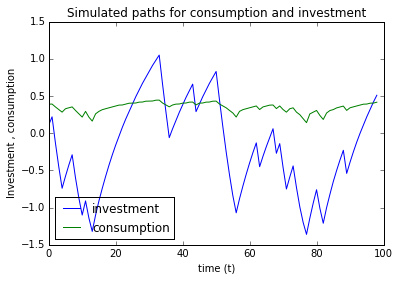

Covariance of consumption and investment: 
[[ 0.0043004   0.03803545]
 [ 0.03803545  0.37343317]]


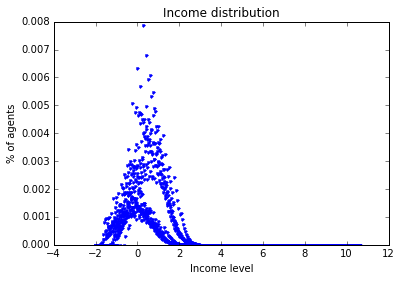

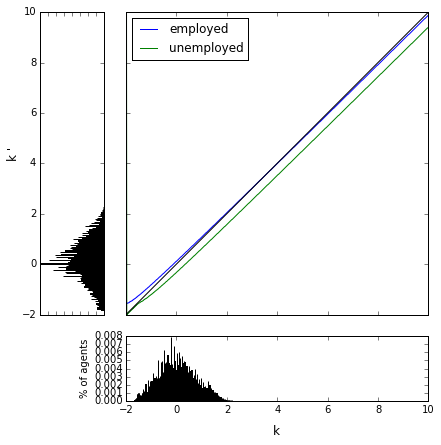

In [9]:
#
#    simulate life histories of the agent
#
print('')
print('SIMULATING LIFE HISTORY');
a = meanA                 # initial level of assets
a = 0
n = 100                   # number of periods to simulate
s0 = 0                    # initial state 
hist = np.zeros((n-1,2))
cons = np.zeros((n-1,1))
invest = np.zeros((n-1,1))
labinc = np.zeros((n-1,1))
agrid = np.linspace(minast,maxast, (maxast-minast)/incast + 1).T
chain = markov(prob,n,s0)

for i in range(0,n-1):
    #history of shocks
    hist[i,:] = np.append(np.array([0.0]),chain[0][i])
    #
    I1 = np.int(np.round((a-minast)/incast) - 1)
    I2 = np.int(np.round((a-minast)/incast))
    if I1==0:
        I1 = 1
        print "NB. I1 = nasset"
    if I2>nasset:
        I2 = nasset
        print "NB. I2 > nasset" 
    weight = (agrid[I2] - a)/incast
    aprime = weight*(decis[I1,chain[0][i]]) +  (1-weight)*(decis[I2,chain[0][i]])
    if chain[0][i] == 0:
        labinc[i] = wage
        cons[i] = wage + R*a - aprime
    else:
        labinc[i] = theta*wage
        cons[i] = wage*theta + R*a - aprime

    a = aprime
    invest[i] = aprime

#Plot stuff
t = arange(0, n-1, 1.0)
plot(t, invest, label = 'investment')
plot(t, cons, label = 'consumption')

xlabel('time (t)')
ylabel('Investment , consumption')
title('Simulated paths for consumption and investment')
legend(loc ='lower left')
show()

print "Covariance of consumption and investment: "
print np.cov(np.hstack([cons, invest]).T)
income = np.hstack([(R*agrid + wage),(R*agrid + wage*theta)])
pinc = np.sort(income)
index = np.argsort(income)
pLambda = Lambda.flatten('F')
plot(pinc, pLambda[index], '.')
xlabel('Income level')
ylabel('% of agents')
title('Income distribution')
show()

#Policy rules and distribution
# start with a rectangular figure
plt.figure(figsize=(6, 6))

# define the axes positions
left = bottom = 0.1
width = height = 0.7

ax_main = plt.axes([left, bottom, width, height])
ax_bottom = plt.axes([left, bottom - 0.2, width, 0.15])
ax_left = plt.axes([left - 0.2, bottom, 0.15, height])
# plot the data points
ax_main.plot(agrid, decis[:,0], label='employed')
ax_main.plot(agrid, decis[:,1], label='unemployed')
ax_main.plot(agrid, agrid, 'black')

#work out savings
savings = np.hstack([(agrid),(agrid)])
psav = np.sort(savings)
indexsav = np.argsort(savings)
# finally plot 1d histograms for the bottom and left axes.
ax_bottom.bar(psav, pLambda[indexsav],width = 0.01)
ax_left.barh(psav, pLambda[index], 0.01)

# make all the limits consistent
ax_bottom.set_xlim(F, 10)
ax_left.set_ylim(F, 10)
ax_main.set_xlim(F, 10)
ax_main.set_ylim(F, 10)

# remove the tick labels
#ax_bottom.set_xticklabels([])
ax_main.set_xticklabels([])
ax_main.set_yticklabels([])
ax_left.set_xticklabels([])
#ax_left.set_yticklabels([])
ax_left.invert_xaxis()

# axis titles
ax_bottom.set_title('k')
ax_bottom.title.set_position([0.5,-0.6,0.0,0.4])
ax_left.set_title("k '", rotation=90)
ax_left.title.set_position([-0.4,0.5,1.0,1.0])
ax_bottom.set_ylabel('% of agents')

ax_main.legend(loc='upper left')
plt.draw()

In [ ]:
# What happens if I give them a one-time transfer of 1.0?
# grid of agents
agrid = np.linspace(minast,maxast, (maxast-minast)/incast + 1).T
# good consumption = wage + savings  - 
congood = wage + R*agrid - agrid[tdecis[:,0]]
conbad  = theta*wage + R*agrid - agrid[tdecis[:,1]]
consum = np.vstack([[congood, conbad]]).T
